In [29]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from asteria.stellardist import StellarDensity
from scipy.interpolate import PchipInterpolator
from scipy.optimize import minimize

In [24]:
def diff(x, r):
    diff = np.abs(Dist2Rate(x) - r)
    return float(diff)

def Dist2Rate(d):
    return sd_ccsn_rate(d)

def Rate2Dist(r_in):
    if not isinstance(r_in, np.ndarray):
        if r_in > sd_ccsn_tot_rate:
            r_in = sd_ccsn_tot_rate
        res = minimize(diff, x0=10, args=r_in)
        return res.x
    else:
        np.where(r_in>sd_ccsn_tot_rate,sd_ccsn_tot_rate,r_in)
        r_out = []
        for rr in r_in:
            res = minimize(diff, x0=10, args=rr)
            r_out.append(res.x)
        r_out = np.array(r_out)
        return r_out
    
def diff_cdf(x, cdf_val):
    if x > 25 + 1E-3: #everything above 25 kpc has a probability of 100%, but we want the 'edge' so we punish any
        # value that is higher than 25 kpc + epsilon, epsilon << 1
        return 1E6
    else:
        diff = np.abs(sd_cdf(x) - cdf_val)
        return float(diff)
    
def inv_cdf(cdf_val):
    if not isinstance(cdf_val, np.ndarray):
        res = minimize(diff_cdf, x0 = 5, args=cv)
        return res.x
    else:
        d = []
        for cv in cdf_val:
            loss, i = 1, 0
            x0s = np.array([5,10,15,20])
            while loss > 1E-3:
                res = minimize(diff_cdf, x0 = x0s[i], args=cv)
                loss = res.fun
                i += 1
                if i > 3:
                    print('Fit failed to converge!')
                    break
            d.append(res.x)
        d = np.array(d)
        return d

In [25]:
trials = 1E4
file1 = open('results_amplitude_IC86+Gen2_{:.0E}_trials.pkl'.format(trials), 'rb')
data1 = pickle.load(file1)
file2 = open('results_amplitude_IC86+Gen2+WLS_{:.0E}_trials.pkl'.format(trials), 'rb')
data2 = pickle.load(file2)

distances1, Sm1_gen2, Sm1_ic86, Bm1_gen2, Bm1_ic86, Z1_gen2, Z1_ic86 = data1
distances2, Sm2_gen2, Sm2_ic86, Bm2_gen2, Bm2_ic86, Z2_gen2, Z2_ic86 = data2

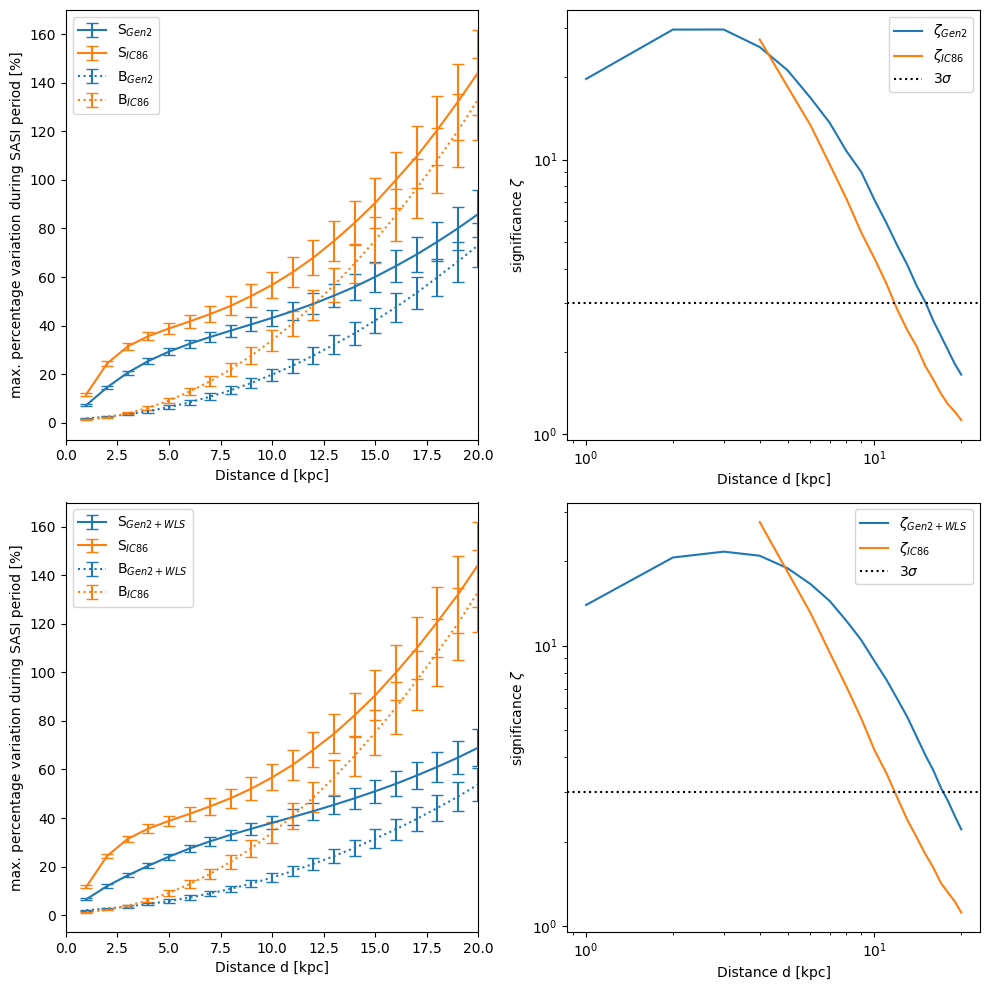

In [18]:
fig, ax = plt.subplots(2,2, figsize = (10,10))
ax = ax.ravel()

ax[0].errorbar(x=distances1, y=Sm1_gen2.T[0],yerr=Sm1_gen2.T[1], capsize=4, color = 'C0', label=r'S$_{Gen2}$')
ax[0].errorbar(x=distances1, y=Sm1_ic86.T[0],yerr=Sm1_ic86.T[1], capsize=4, color = 'C1', label=r'S$_{IC86}$')
ax[0].errorbar(x=distances1, y=Bm1_gen2.T[0],yerr=Bm1_gen2.T[1], capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2}$')
ax[0].errorbar(x=distances1, y=Bm1_ic86.T[0],yerr=Bm1_ic86.T[1], capsize=4, color = 'C1', ls = ':', label=r'B$_{IC86}$')
ax[0].set_xlabel('Distance d [kpc]')
ax[0].set_ylabel('max. percentage variation during SASI period [%]')
ax[0].set_xlim((0,20))
ax[0].legend()

ax[1].plot(distances1, Z1_gen2, color = 'C0', label=r'$\zeta_{Gen2}$')
ax[1].plot(distances1, Z1_ic86, color = 'C1', label=r'$\zeta_{IC86}$')
ax[1].axhline(3, color='k', ls = ':', label = '3$\sigma$')
ax[1].set_xlabel('Distance d [kpc]')
ax[1].set_ylabel('significance $\zeta$')
#ax[1].set_xlim((0,20))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()

ax[2].errorbar(x=distances1, y=Sm2_gen2.T[0],yerr=Sm2_gen2.T[1], capsize=4, color = 'C0', label=r'S$_{Gen2+WLS}$')
ax[2].errorbar(x=distances1, y=Sm2_ic86.T[0],yerr=Sm2_ic86.T[1], capsize=4, color = 'C1', label=r'S$_{IC86}$')
ax[2].errorbar(x=distances1, y=Bm2_gen2.T[0],yerr=Bm2_gen2.T[1], capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2+WLS}$')
ax[2].errorbar(x=distances1, y=Bm2_ic86.T[0],yerr=Bm2_ic86.T[1], capsize=4, color = 'C1', ls = ':', label=r'B$_{IC86}$')
ax[2].set_xlabel('Distance d [kpc]')
ax[2].set_ylabel('max. percentage variation during SASI period [%]')
ax[2].set_xlim((0,20))
ax[2].legend()

ax[3].plot(distances1, Z2_gen2, color = 'C0', label=r'$\zeta_{Gen2+WLS}$')
ax[3].plot(distances1, Z2_ic86, color = 'C1', label=r'$\zeta_{IC86}$')
ax[3].axhline(3, color='k', ls = ':', label = '3$\sigma$')
ax[3].set_xlabel('Distance d [kpc]')
ax[3].set_ylabel('significance $\zeta$')
#ax[1].set_xlim((0,20))
ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].legend()

plt.tight_layout()

In [26]:
# stellar distribution file, Adams 2013 model, returns CDF
sd = StellarDensity('../../../data/stellar/sn_radial_distrib_adams.fits')
sd_ccsn_tot_rate = 3.2 # 3.2 CCSNe/century
sd_ccsn_rate = PchipInterpolator(sd.dist.value, sd.cdf*sd_ccsn_tot_rate)

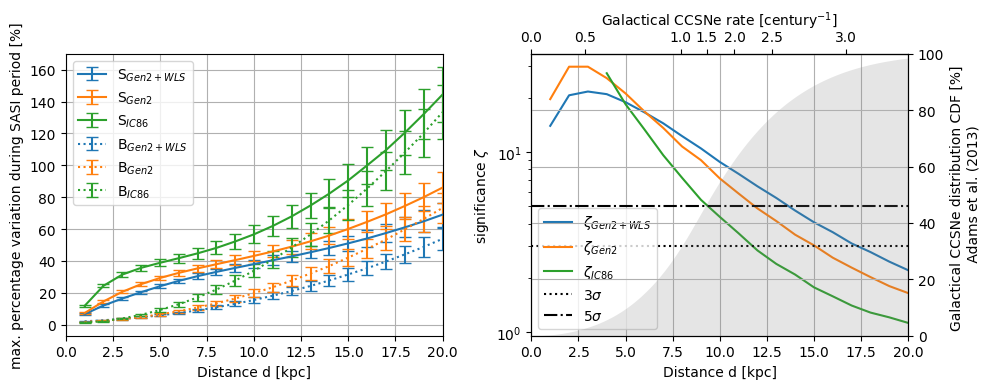

In [27]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax = ax.ravel()

ax[0].errorbar(x=distances2, y=Sm2_gen2.T[0],yerr=Sm2_gen2.T[1], capsize=4, color = 'C0', label=r'S$_{Gen2+WLS}$')
ax[0].errorbar(x=distances1, y=Sm1_gen2.T[0],yerr=Sm1_gen2.T[1], capsize=4, color = 'C1', label=r'S$_{Gen2}$')
ax[0].errorbar(x=distances1, y=Sm1_ic86.T[0],yerr=Sm1_ic86.T[1], capsize=4, color = 'C2', label=r'S$_{IC86}$')
ax[0].errorbar(x=distances2, y=Bm2_gen2.T[0],yerr=Bm2_gen2.T[1], capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2+WLS}$')
ax[0].errorbar(x=distances1, y=Bm1_gen2.T[0],yerr=Bm1_gen2.T[1], capsize=4, color = 'C1', ls = ':', label=r'B$_{Gen2}$')
ax[0].errorbar(x=distances1, y=Bm1_ic86.T[0],yerr=Bm1_ic86.T[1], capsize=4, color = 'C2', ls = ':', label=r'B$_{IC86}$')
ax[0].set_xlabel('Distance d [kpc]')
ax[0].set_ylabel('max. percentage variation during SASI period [%]')
ax[0].set_xlim((0,20))
ax[0].legend()
ax[0].grid()

ax[1].plot(distances1, Z2_gen2, color = 'C0', label=r'$\zeta_{Gen2+WLS}$')
ax[1].plot(distances1, Z1_gen2, color = 'C1', label=r'$\zeta_{Gen2}$')
ax[1].plot(distances1, Z1_ic86, color = 'C2', label=r'$\zeta_{IC86}$')
ax[1].axhline(3, color='k', ls = ':', label = '3$\sigma$')
ax[1].axhline(5, color='k', ls = '-.', label = '5$\sigma$')
ax[1].set_xlabel('Distance d [kpc]')
ax[1].set_ylabel('significance $\zeta$')
ax[1].set_xlim((0,20))
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
#ax[1].legend(loc='lower left')
ax[1].grid(axis='x')
ax[1].legend(loc='lower left')

ax12 = ax[1].twinx()
#ax12.plot(sd.dist.value, sd.cdf*100, color='k', ls='-', lw = 1)
ax12.fill_between(x=sd.dist.value, y1=sd.cdf*100,y2=np.zeros_like(sd.cdf), color='grey', lw = 0, alpha = 0.2)
ax12.set_ylabel('Galactical CCSNe distribution CDF [%] \n Adams et al. (2013)')
ax12.set_xlim(0,20)
ax12.set_ylim(0,100)
ax12.grid(axis='y')

ax22 = ax[1].secondary_xaxis('top', functions=(Dist2Rate, Rate2Dist))
ax22.set_xlabel(r'Galactical CCSNe rate [century$^{-1}$]')

plt.tight_layout()

In [30]:
# stellar distribution file, Adams 2013 model, returns CDF
sd = StellarDensity('../../../data/stellar/sn_radial_distrib_adams.fits', add_LMC=False, add_SMC=False)

dmax = np.max((distances1,distances2))*u.kpc
sd_cdf = PchipInterpolator(sd.dist.value, sd.cdf)

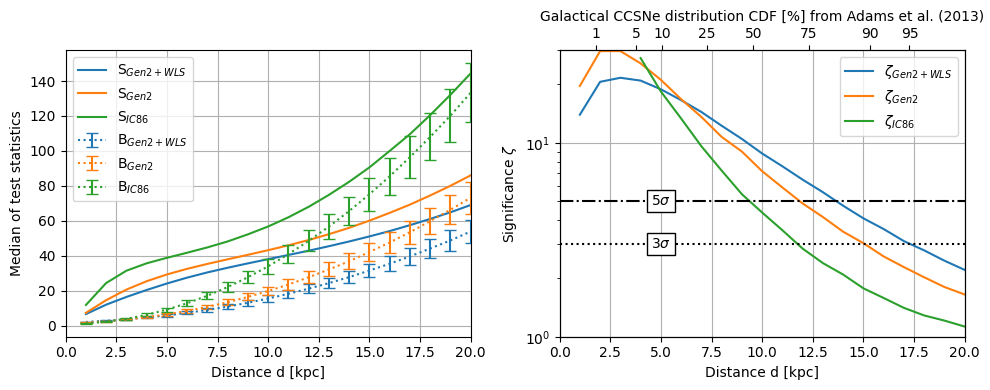

In [53]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax = ax.ravel()

ax[0].plot(distances2, Sm2_gen2.T[0], color = 'C0', label=r'S$_{Gen2+WLS}$')
ax[0].plot(distances1, Sm1_gen2.T[0], color = 'C1', label=r'S$_{Gen2}$')
ax[0].plot(distances1, Sm1_ic86.T[0], color = 'C2', label=r'S$_{IC86}$')
#ax[0].errorbar(x=distances, y=Sm2_gen2.T[0],yerr=(Sm2_gen2.T[0]-Sm2_gen2.T[1],Sm2_gen2.T[2]-Sm2_gen2.T[0]), 
#capsize=4, color = 'C0', label=r'S$_{Gen2+WLS}$')
#ax[0].errorbar(x=distances, y=Sm1_gen2.T[0],yerr=(Sm1_gen2.T[0]-Sm1_gen2.T[1],Sm1_gen2.T[2]-Sm1_gen2.T[0]), 
#capsize=4, color = 'C0', label=r'S$_{Gen2}$')
#ax[0].errorbar(x=distances, y=Sm1_ic86.T[0],yerr=(Sm1_ic86.T[0]-Sm1_ic86.T[1],Sm1_ic86.T[2]-Sm1_ic86.T[0]), 
#capsize=4, color = 'C1', label=r'S$_{IC86}$')

ax[0].errorbar(x=distances2, y=Bm2_gen2.T[0],yerr=(Bm2_gen2.T[0]-Bm2_gen2.T[1],Bm2_gen2.T[2]-Bm2_gen2.T[0]), 
               capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2+WLS}$')
ax[0].errorbar(x=distances1, y=Bm1_gen2.T[0],yerr=(Bm1_gen2.T[0]-Bm1_gen2.T[1],Bm1_gen2.T[2]-Bm1_gen2.T[0]), 
               capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2}$')
ax[0].errorbar(x=distances1, y=Bm1_ic86.T[0],yerr=(Bm1_ic86.T[0]-Bm1_ic86.T[1],Bm1_ic86.T[2]-Bm1_ic86.T[0]), 
               capsize=4, color = 'C1', ls = ':', label=r'B$_{IC86}$')
#ax[0].errorbar(x=distances2, y=Bm2_gen2.T[0],yerr=Bm2_gen2.T[1], capsize=4, color = 'C0', ls = ':', label=r'B$_{Gen2+WLS}$')
#ax[0].errorbar(x=distances1, y=Bm1_gen2.T[0],yerr=Bm1_gen2.T[1], capsize=4, color = 'C1', ls = ':', label=r'B$_{Gen2}$')
#ax[0].errorbar(x=distances1, y=Bm1_ic86.T[0],yerr=Bm1_ic86.T[1], capsize=4, color = 'C2', ls = ':', label=r'B$_{IC86}$')

ax[0].set_xlabel('Distance d [kpc]')
ax[0].set_ylabel('Median of test statistics')
ax[0].set_xlim((0,20))
#ax[0].set_yscale('log')
ax[0].legend()
ax[0].grid()

ax[1].plot(distances1, Z2_gen2, color = 'C0', label=r'$\zeta_{Gen2+WLS}$')
ax[1].plot(distances1, Z1_gen2, color = 'C1', label=r'$\zeta_{Gen2}$')
ax[1].plot(distances1, Z1_ic86, color = 'C2', label=r'$\zeta_{IC86}$')
ax[1].axhline(3, color='k', ls = ':')
ax[1].axhline(5, color='k', ls = '-.')
ax[1].set_xlabel('Distance d [kpc]')
ax[1].set_ylabel('Significance $\zeta$')
ax[1].set_xlim((0,20))
ax[1].set_ylim((1,30))
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
#ax[1].legend(loc='lower left')
ax[1].grid()
ax[1].legend(loc='upper right')


ax[1].text(5, 3, r"3$\sigma$", size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

ax[1].text(5, 5, r"5$\sigma$", size=10,
         ha="center", va="center",
         bbox=dict(boxstyle="square", ec='k', fc='white'))

rates = np.array([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95])
ax22 = ax[1].twiny()
ax22.set_xlim(ax[1].get_xlim())
ax22.set_xticks(inv_cdf(rates).flatten())
ax22.set_xticklabels((rates*100).astype(dtype=int), rotation = 0)
ax22.set_xlabel('Galactical CCSNe distribution CDF [%] from Adams et al. (2013)')
plt.tight_layout()